In [1]:
%pylab inline
import sys
from sklearn.externals import joblib
from user_function import MyAlgorithm
from alcon_utils import AlconUtils
import numpy as np
import cv2

import keras
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
import tensorflow
import cProfile, pstats

import os.path
import pickle
import matplotlib.pyplot as plt

config = tensorflow.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.93
keras.backend.tensorflow_backend.set_session(tensorflow.Session(config=config))

# 初期化
datasetdir = "/share/alcon/dataset/"
alcon = AlconUtils(datasetdir)

Using TensorFlow backend.


In [45]:
pr = cProfile.Profile()
pr.enable()

# アノテーションの読み込み
alcon.load_annotations_target("target_lv1_iiyama_0.9.csv")
alcon.load_annotations_ground("groundtruth_lv1_iiyama_0.9.csv")

dataset = {}
for bb_id, target in alcon.targets.items():
    code = alcon.ground_truth[bb_id][0]
    if code not in dataset:
        dataset[code] = []
    if len(dataset[code]) == 300:
        continue
    img_filename = alcon.get_filename_char( bb_id )
    img = cv2.imread( img_filename )
    feature = MyAlgorithm.feature_extraction(img)
    dataset[code].append(feature)

labels = []
data = []
classes = sorted(dataset.keys())

for label, values in dataset.items():
    labels += [classes.index(label)] * len(values)
    data += values

num_classes = 46
input_shape = (32, 32, 1)# img_rows img_cols channel

x_data = np.asarray(data).reshape(len(data), *input_shape)
y_train = keras.utils.to_categorical( labels, num_classes )
datasetdir = "/share/alcon/dataset/"
annotation_name = "test_5"

# 初期化
alcon = AlconUtils(datasetdir)
myalgorithm = MyAlgorithm(datasetdir)

# ターゲットの読み込み
file_name_last = "_lv1_" + annotation_name + ".csv"
alcon.load_annotations_target("target" + file_name_last)

pr.disable()
pstats.Stats(pr).sort_stats('tottime').print_stats(5)

         482548 function calls in 113.226 seconds

   Ordered by: internal time
   List reduced from 51 to 5 due to restriction <5>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    12998   89.744    0.007   89.744    0.007 {bilateralFilter}
    12998   22.272    0.002   22.272    0.002 {imread}
    12998    0.197    0.000    0.197    0.000 {cvtColor}
    12998    0.196    0.000    0.196    0.000 {threshold}
        1    0.171    0.171  113.007  113.007 <ipython-input-45-3403e1b54a1d>:9(<module>)




In [2]:
#　学習機に掛ける前の準備
pr = cProfile.Profile()
pr.enable()
config = tensorflow.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.93
keras.backend.tensorflow_backend.set_session(tensorflow.Session(config=config))

# 初期化
datasetdir = "/share/alcon/dataset/"
alcon = AlconUtils(datasetdir)

# アノテーションの読み込み
alcon.load_annotations_target("target_lv1_iiyama_0.9.csv")
alcon.load_annotations_ground("groundtruth_lv1_iiyama_0.9.csv")

dataset = {}
with open('full_dataset0.9', mode='rb') as f:
    dataset = pickle.load(f)
labels = []
data = []
classes = sorted(dataset.keys())

for label, values in dataset.items():
    labels += [classes.index(label)] * len(values)
    data += values

num_classes = 46
input_shape = (32, 32, 1)# img_rows img_cols channel
datagen = ImageDataGenerator(
    #featurewise_center=True,
    #featurewise_std_normalization=True,
    zca_whitening=True
    #rotation_range=20,
    #width_shift_range=0.1,
    #height_shift_range=0.1,
    #shear_range=0.3,
    #zoom_range=0.1,
    #fill_mode='constant',
    #cval=0.
)
x_train = np.asarray(data).reshape(len(data), *input_shape)
y_train = keras.utils.to_categorical( labels, num_classes )
datagen.fit(x_train)
datasetdir = "/share/alcon/dataset/"
annotation_name = "test_5"

# 初期化
alcon = AlconUtils(datasetdir)
myalgorithm = MyAlgorithm(datasetdir)

# ターゲットの読み込み
file_name_last = "_lv1_" + annotation_name + ".csv"
alcon.load_annotations_target("target" + file_name_last)

pr.disable()
pstats.Stats(pr).sort_stats('tottime').print_stats(0)

         849849 function calls (831713 primitive calls) in 4.271 seconds

   Ordered by: internal time
   List reduced from 1049 to 5 due to restriction <5>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        5    1.607    0.321    1.607    0.321 {built-in method _pywrap_tensorflow_internal.TF_Run}
        1    0.406    0.406    0.407    0.407 /root/.pyenv/versions/3.6.1/lib/python3.6/site-packages/scipy/linalg/decomp_svd.py:16(svd)
      578    0.175    0.000    0.196    0.000 {built-in method numpy.core.multiarray.array}
        1    0.169    0.169    0.169    0.169 {built-in method _pickle.load}
        3    0.158    0.053    0.158    0.053 {built-in method numpy.core.multiarray.dot}




In [10]:
pr = cProfile.Profile()
pr.enable()
classifier = keras.models.Sequential()
classifier.add(keras.layers.normalization.BatchNormalization(input_shape = input_shape))
classifier.add(Conv2D(32, kernel_size=(3,3), activation='relu')) # 30*30
classifier.add(Conv2D(64,                 (3,3), activation='relu')) # 28*28 
classifier.add(Dropout(0.5))
classifier.add(MaxPooling2D(pool_size=(4,4)))                      # 7*7
classifier.add(Flatten())
classifier.add(Dense(480, activation='relu'))
classifier.add(Dropout(7/24))
classifier.add(Dense(128, activation='relu'))
classifier.add(Dropout(0.5))
classifier.add(Dense(num_classes, activation='softmax'))

classifier.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Nadam(), metrics=['accuracy'])


history = classifier.fit(x_train, y_train, batch_size= 84, epochs=50,
                      callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)],
                      validation_data=(x_train, y_train))
"""
history = classifier.fit_generator(datagen.flow(x_train, y_train, batch_size=500),
                                         steps_per_epoch=len(x_train))

                                         #epochs = 1
"""
plt.plot(history.history['acc'])

joblib.dump(classes, "./model.pkl")
classifier.save("./model2.pkl")





for bb_id, target in alcon.targets.items():
    img_file_id, *bb = target
    # 認識処理（ここで各自のアルゴリズムを呼び出します）
    # boundingbox id と紐付けて保存
    results[bb_id] = myalgorithm.predict(imgs[bb_id], bb)


# 評価
alcon.load_annotations_ground("groundtruth" + file_name_last)
alcon.evaluation( results )

pr.disable()
pstats.Stats(pr).sort_stats('tottime').print_stats(0)

Train on 44353 samples, validate on 44353 samples
Epoch 1/50
44353/44353 [==============================] - 11s - loss: 1.4227 - acc: 0.6345 - val_loss: 1.1355 - val_acc: 0.7179
Epoch 2/50
44353/44353 [==============================] - 11s - loss: 0.6983 - acc: 0.8147 - val_loss: 0.5912 - val_acc: 0.8733
Epoch 3/50
44353/44353 [==============================] - 11s - loss: 0.5175 - acc: 0.8600 - val_loss: 0.3755 - val_acc: 0.9199
Epoch 4/50
44353/44353 [==============================] - 11s - loss: 0.4257 - acc: 0.8827 - val_loss: 0.2772 - val_acc: 0.9586
Epoch 5/50
44353/44353 [==============================] - 11s - loss: 0.3549 - acc: 0.9030 - val_loss: 0.1819 - val_acc: 0.9699
Epoch 6/50
44353/44353 [==============================] - 11s - loss: 0.3135 - acc: 0.9125 - val_loss: 0.1610 - val_acc: 0.9747
Epoch 7/50
44353/44353 [==============================] - 11s - loss: 0.2766 - acc: 0.9229 - val_loss: 0.1457 - val_acc: 0.9779
Epoch 8/50
44353/44353 [==============================

In [3]:
# テスト　imread
pr = cProfile.Profile()
pr.enable()
datasetdir = "/share/alcon/dataset/"
annotation_name = "test_5"
"""
評価コードのメイン
:param datasetdir データセットを格納したディレクトリへのパス
"""

# 初期化
alcon = AlconUtils(datasetdir)
myalgorithm = MyAlgorithm(datasetdir)

# ターゲットの読み込み
file_name_last = "_lv1_" + annotation_name + ".csv"
alcon.load_annotations_target("target" + file_name_last)

imgs = {}
results = {}
# １ターゲットずつ認識していくループ
for bb_id, target in alcon.targets.items():
    img_file_id, *bb = target
    # ページ全体の画像
    imgs[bb_id] = cv2.imread( os.path.join(datasetdir, "images", img_file_id+".jpg") )

pr.disable()
pstats.Stats(pr).sort_stats('tottime').print_stats(3)

         672751 function calls (654781 primitive calls) in 25.370 seconds

   Ordered by: internal time
   List reduced from 968 to 5 due to restriction <5>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      230   23.824    0.104   23.824    0.104 {imread}
        3    0.123    0.041    0.123    0.041 {built-in method _pywrap_tensorflow_internal.TF_ExtendGraph}
        5    0.112    0.022    0.112    0.022 {built-in method _pywrap_tensorflow_internal.TF_Run}
     1390    0.107    0.000    0.120    0.000 /root/.pyenv/versions/3.6.1/lib/python3.6/site-packages/tensorflow/python/framework/ops.py:1202(<listcomp>)
1105/1097    0.097    0.000    0.973    0.001 /root/.pyenv/versions/3.6.1/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:289(apply_op)




In [16]:
# テストpredict
pr = cProfile.Profile()
pr.enable()

datasetdir = "/share/alcon/dataset/"
"""
評価コードのメイン
:param datasetdir データセットを格納したディレクトリへのパス
"""

# 初期化
alcon = AlconUtils(datasetdir)
myalgorithm = MyAlgorithm(datasetdir)

# ターゲットの読み込み
alcon.load_annotations_target("target_lv1_test_5.csv")

for bb_id, target in alcon.targets.items():
    img_file_id, *bb = target
    # 認識処理（ここで各自のアルゴリズムを呼び出します）
    # boundingbox id と紐付けて保存
    results[bb_id] = myalgorithm.predict(imgs[bb_id], bb)


# 評価
alcon.load_annotations_ground("groundtruth" + file_name_last)
alcon.evaluation( results )

pr.disable()
pstats.Stats(pr).sort_stats('tottime').print_stats(5)

results: 111 / 230
score: 48.260870
         862912 function calls (844466 primitive calls) in 6.569 seconds

   Ordered by: internal time
   List reduced from 1002 to 5 due to restriction <5>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      230    3.153    0.014    3.153    0.014 {bilateralFilter}
        4    1.107    0.277    1.107    0.277 {built-in method _pywrap_tensorflow_internal.TF_ExtendGraph}
      235    0.766    0.003    0.766    0.003 {built-in method _pywrap_tensorflow_internal.TF_Run}
1106/1098    0.098    0.000    0.874    0.001 /root/.pyenv/versions/3.6.1/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:289(apply_op)
     1274    0.051    0.000    0.051    0.000 {built-in method _pywrap_tensorflow_internal.RunCppShapeInference}




In [24]:
import pickle
with open('dataso', 'wb') as f:
    pickle.dump(dataset, f)

In [28]:
i = 0
for bb_id, target in alcon.targets.items():
    i += 1
    if i > 350*4: break
    img_file_id, *bb = target
    if i % 50 == 1: print(i)
    # ページ全体の画像
    imgs[bb_id] = cv2.imread( os.path.join(datasetdir, "images", img_file_id+".jpg") )

AttributeError: 'dict' object has no attribute 'shape'

In [46]:
x_data = datagen.reshape()

In [7]:
with open('full_dataset0.9', 'wb') as f:
    pickle.dump(dataset, f)

KeyboardInterrupt: 

Populating the interactive namespace from numpy and matplotlib


/root/.pyenv/versions/3.6.1/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


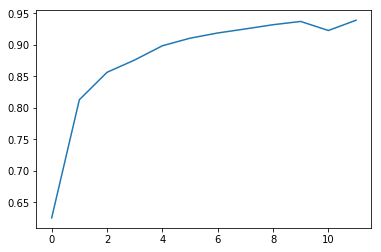